In [1]:
import numpy as np
import torch
import espaloma as esp

Using backend: pytorch


In [65]:
ds = esp.data.dataset.GraphDataset.load("zinc_param")

In [66]:
len(ds)

752

In [49]:
# define a layer
layer = esp.nn.layers.dgl_legacy.gn("SAGEConv")

# define a representation
representation = esp.nn.Sequential(
        layer,
        [128, "relu", 128, "relu", 128, "relu"],
)

# define a readout
readout = esp.nn.readout.node_typing.NodeTyping(
        in_features=128,
        n_classes=100
) # not too many elements here I think?

net = torch.nn.Sequential(
    representation,
    readout
)

In [50]:
net.load_state_dict(
    torch.load(
        "results/net1300.th"
    )
)

<All keys matched successfully>

In [51]:
for name, param in net.named_parameters():
    print(name)

0.f_in.0.weight
0.f_in.0.bias
0._sequential.d0.gn.bias
0._sequential.d0.gn.fc_self.weight
0._sequential.d0.gn.fc_neigh.weight
0._sequential.d2.gn.bias
0._sequential.d2.gn.fc_self.weight
0._sequential.d2.gn.fc_neigh.weight
0._sequential.d4.gn.bias
0._sequential.d4.gn.fc_self.weight
0._sequential.d4.gn.fc_neigh.weight
1.c.weight
1.c.bias


In [52]:
import dgl
dgl.__version__

'0.6.1'

In [53]:
list(
    torch.load(
        "results/net1300.th"
    ).keys()
)

['0.f_in.0.weight',
 '0.f_in.0.bias',
 '0._sequential.d0.gn.bias',
 '0._sequential.d0.gn.fc_self.weight',
 '0._sequential.d0.gn.fc_neigh.weight',
 '0._sequential.d2.gn.bias',
 '0._sequential.d2.gn.fc_self.weight',
 '0._sequential.d2.gn.fc_neigh.weight',
 '0._sequential.d4.gn.bias',
 '0._sequential.d4.gn.fc_self.weight',
 '0._sequential.d4.gn.fc_neigh.weight',
 '1.c.weight',
 '1.c.bias']

In [54]:
g = next(iter(ds.view(batch_size=len(ds))))

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: From v0.5, DGLHeteroGraph is merged into DGLGraph. You can safely replace dgl.batch_hetero with dgl.batch
  return warnings.warn(message, category=category, stacklevel=1)


In [55]:
g = net(g)

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)


In [56]:
idx_2_str = esp.graphs.legacy_force_field.LegacyForceField("gaff-1.81")._idx_2_str

In [57]:
y_pred = g.nodes['n1'].data['nn_typing'].argmax(dim=-1)
y_true = g.nodes['n1'].data['legacy_typing']

In [58]:
y_pred = [idx_2_str[idx.item()] for idx in y_pred]
y_true = [idx_2_str[idx.item()]for idx in y_true]

In [59]:
pairs = list(zip(y_true, y_pred))

In [60]:
cs = ["c", "c1", "c2", "c3", "ca", "cc", "cp", "ce"]
idx_2_str_c = dict(zip(range(len(cs)), cs))
str_2_idx_c = dict(zip(cs, range(len(cs))))
pairs = [pair for pair in pairs if pair[0] in cs and pair[1] in cs]

In [61]:
confusion = np.zeros((len(cs), len(cs)))
for x, y in pairs:
    confusion[
        str_2_idx_c[x], str_2_idx_c[y]
    ] += 1
confusion /= confusion.sum(axis=0, keepdims=True)
confusion *= 100
confusion[confusion == 0] = np.nan

In [62]:
abundance = {c: 0 for c in cs}
for x, y in pairs:
    if x in cs:
        abundance[x] += 1

abundance = {key: value / len(pairs) for key, value in abundance.items()}

In [63]:
len(pairs)

8046

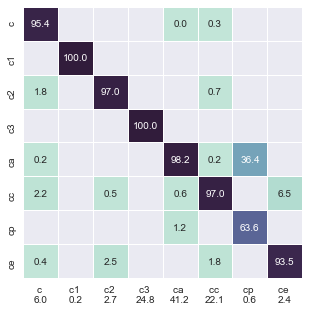

In [64]:
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
sns.set_style("dark")
sns.heatmap(
    confusion, 
    linewidths=.5, 
    annot=True, 
    fmt=".1f",
    xticklabels=["%s \n%.1f" % (c, abundance[c] * 100) for c in str_2_idx_c.keys()],
    yticklabels=str_2_idx_c.keys(),
    cmap=sns.cubehelix_palette(start=.5, rot=-.5,as_cmap=True2),
    cbar=False,
)
plt.savefig("wrongs.png", dpi=300)
